# Enron dataset analysis

Open this preferrably in [nbviewer](https://nbviewer.jupyter.org/github/xR86/ml-stuff/blob/master/kaggle/enron-email/Initial.ipynb), so that svgs can also be rendered.

In [1]:
# built-in libs
import email

# processing libs
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# visualization libs
import matplotlib.pyplot as plt
%matplotlib inline

# display libs
from tqdm import tqdm

## Read data

In [2]:
emails_full_df = pd.read_csv('emails.csv', chunksize=10000)
emails_df = next(emails_full_df)

In [3]:
print(emails_df.shape)
emails_df.head()

(10000, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
file       10000 non-null object
message    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


## Cleaning data

In [5]:
msg = email.message_from_string(emails_df.message[0])
print('From: %s' % msg['from'])
print('To:   %s' % msg['to'])
print()
print(msg.get_payload(decode=True))
print()
print(str(msg).strip())

From: phillip.allen@enron.com
To:   tim.belden@enron.com

b'Here is our forecast\n\n '

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast


In [6]:
%time
messages_obj_lst = []
messages_str_lst = []

message_metadata = {}

for i in tqdm(range(emails_df.shape[0])):
    msg = email.message_from_string(emails_df.message[i])
    
    for msg_property in msg:
        if msg_property in message_metadata:
            message_metadata[msg_property][i] = msg[msg_property]
        else:
            message_metadata[msg_property] = ['N/A'] * emails_df.shape[0]
    
    payload = msg.get_payload() #decode=True
    
    messages_obj_lst.append(msg)
    messages_str_lst.append(payload) #.encode('utf-8').decode('unicode_escape')
    #except KeyboardInterrupt:
    #    break

print('messages_obj_lst size: %i' % len(messages_obj_lst))

Wall time: 0 ns


100%|██████████████████████████████████| 10000/10000 [00:07<00:00, 1302.75it/s]


messages_obj_lst size: 10000


In [7]:
# update dataframe object
#emails_df.rename(columns = {'message':'message_obj'}, inplace = True)
emails_df = emails_df.assign(message_obj = pd.Series(messages_obj_lst).values)
emails_df = emails_df.assign(payload     = pd.Series(messages_str_lst).values)

#print(emails_df.payload.str.contains(r'\\'))
emails_df['payload'] = emails_df.payload.str.replace(r'\n', '')

In [8]:
emails_df.head()

,file,message,message_obj,payload
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"[Message-ID, Date, From, To, Subject, Mime-Ver...",test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"[Message-ID, Date, From, To, Subject, Mime-Ver...","Randy, Can you send me a schedule of the salar..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Let's shoot for Tuesday at 11:45.


## Analyzing metadata

In [9]:
emails_meta_df = emails_df.drop('message', axis=1)
emails_meta_df.head()

,file,message_obj,payload
0,allen-p/_sent_mail/1.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Here is our forecast
1,allen-p/_sent_mail/10.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",test successful. way to go!!!
3,allen-p/_sent_mail/1000.,"[Message-ID, Date, From, To, Subject, Mime-Ver...","Randy, Can you send me a schedule of the salar..."
4,allen-p/_sent_mail/1001.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Let's shoot for Tuesday at 11:45.


In [10]:
print(emails_meta_df.message_obj[0]['From'])
#print(emails_meta_df['message_obj']['From'])

emails_meta_df = emails_meta_df.assign(Message_ID = pd.Series(message_metadata['Message-ID']).values)
emails_meta_df = emails_meta_df.assign(Date       = pd.Series(message_metadata['Date']).values)
emails_meta_df = emails_meta_df.assign(From       = pd.Series(message_metadata['From']).values)
emails_meta_df = emails_meta_df.assign(To         = pd.Series(message_metadata['To']).values)
emails_meta_df = emails_meta_df.assign(Subject    = pd.Series(message_metadata['Subject']).values)
emails_meta_df = emails_meta_df.assign(Mime_Version = pd.Series(message_metadata['Mime-Version']).values)
emails_meta_df = emails_meta_df.assign(Content_Type = pd.Series(message_metadata['Content-Type']).values)
emails_meta_df = emails_meta_df.assign(Content_Transfer_Encoding = pd.Series(message_metadata['Content-Transfer-Encoding']).values)
emails_meta_df = emails_meta_df.assign(X_From = pd.Series(message_metadata['X-From']).values)
emails_meta_df = emails_meta_df.assign(X_To = pd.Series(message_metadata['X-To']).values)
emails_meta_df = emails_meta_df.assign(X_cc = pd.Series(message_metadata['X-cc']).values)
emails_meta_df = emails_meta_df.assign(X_bcc = pd.Series(message_metadata['X-bcc']).values)

emails_meta_df = emails_meta_df.assign(X_Folder = pd.Series(message_metadata['X-Folder']).values)
emails_meta_df = emails_meta_df.assign(X_Origin = pd.Series(message_metadata['X-Origin']).values)
emails_meta_df = emails_meta_df.assign(X_FileName = pd.Series(message_metadata['X-FileName']).values)

phillip.allen@enron.com


In [11]:
emails_meta_df.head()

,file,message_obj,payload,Message_ID,Date,From,To,Subject,Mime_Version,Content_Type,Content_Transfer_Encoding,X_From,X_To,X_cc,X_bcc,X_Folder,X_Origin,X_FileName
0,allen-p/_sent_mail/1.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Here is our forecast,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,allen-p/_sent_mail/10.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Traveling to have a business meeting takes the...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",test successful. way to go!!!,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,"[Message-ID, Date, From, To, Subject, Mime-Ver...","Randy, Can you send me a schedule of the salar...",<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,"[Message-ID, Date, From, To, Subject, Mime-Ver...",Let's shoot for Tuesday at 11:45.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [12]:
# Analyzing ranges for metadata
print(len(emails_meta_df['From'].unique()))
print(len(emails_meta_df['To'].unique()))

print(emails_meta_df['Mime_Version'].unique()) #can be safely ignored
print(emails_meta_df['Content_Type'].unique())
print(emails_meta_df['Content_Transfer_Encoding'].unique())
print(len(emails_meta_df['X_cc'].unique()))
print(len(emails_meta_df['X_bcc'].unique()))
print(len(emails_meta_df['X_Folder'].unique()))
print(emails_meta_df['X_Origin'].unique())
print(emails_meta_df['X_FileName'].unique())

#print(emails_meta_df['From'].value_counts('phillip.allen@enron.com'))

755
1335
['N/A' '1.0']
['N/A' 'text/plain; charset=us-ascii' 'text/plain; charset=ANSI_X3.4-1968']
['N/A' '7bit' 'quoted-printable']
422
3
126
['N/A' 'Allen-P' 'Arnold-J' 'ARNOLD-J' 'ARORA-H' 'Arora-H' 'Badeer-R'
 'BAILEY-S' 'Bailey-S' 'BASS-E' 'Bass-E']
['N/A' 'pallen (Non-Privileged).pst' 'pallen.nsf'
 'PALLEN (Non-Privileged).pst' 'Jarnold.nsf' 'jarnold.nsf'
 'JARNOLD (Non-Privileged).pst' 'jarnold (Non-Privileged).pst' 'harora.nsf'
 'harora (Non-Privileged).pst' 'HARORA (Non-Privileged).pst' 'rbadeer.nsf'
 'rbadeer (Non-Privileged).pst' 'sbailey2.nsf'
 'sbaile2 (Non-Privileged).pst' 'SBAILE2 (Non-Privileged).pst'
 'eric bass 6-25-02.PST' 'ebass.nsf']


## Payload word cloud (on decoded payload - no preprocessing)
### Bag-of-words

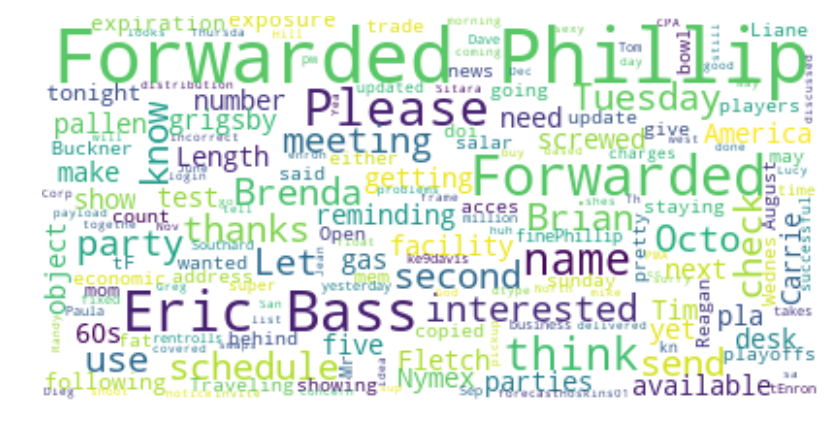

In [13]:
wordcloud = WordCloud(
    #width=1200,
    #height=800,
    margin=0,
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
 ).generate(str(emails_df['payload']))

plt.rcParams['figure.dpi'] = 600 #72
plt.rcParams['figure.figsize'] = (10,8)

print(wordcloud)
plt.imshow(wordcloud, interpolation='bilinear') #, interpolation='bilinear'
plt.axis('off')
plt.show()

## NLP tools

In [14]:
import nltk
from nltk.corpus import stopwords

emails_nlp_df = emails_df.drop(['message', 'message_obj'], axis=1)
emails_nlp_df.head()

,file,payload
0,allen-p/_sent_mail/1.,Here is our forecast
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,"Randy, Can you send me a schedule of the salar..."
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.


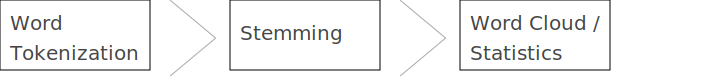

In [27]:
%%svg
<svg width="720" height="80">
    <g>
        <g>
            <rect x="0" y="0" width="150" height="70" fill="#FFF" stroke="#000"></rect>
            <text x="10" y="30" font-family="Verdana" font-size="20" fill="#444">Word</text>
            <text x="10" y="60" font-family="Verdana" font-size="20" fill="#444">Tokenization</text>
        </g>

        <g transform="translate(170,0)">
         <polyline fill="none" stroke="#AAA" stroke-width="1" stroke-linecap="round" stroke-linejoin="round" points="
            0.375,0.375 45.63,38.087 0.375,75.8 "/>
        </g>

        <g transform="translate(230,0)">
            <rect x="0" y="0" width="150" height="70" fill="#FFF" stroke="#000"></rect>
            <text x="10" y="40" font-family="Verdana" font-size="20" fill="#444">Stemming</text>
        </g>

        <g transform="translate(400,0)">
         <polyline fill="none" stroke="#AAA" stroke-width="1" stroke-linecap="round" stroke-linejoin="round" points="
            0.375,0.375 45.63,38.087 0.375,75.8 "/>
        </g>

         <g transform="translate(460,0)">
            <rect x="0" y="0" width="150" height="70" fill="#FFF" stroke="#000"></rect>
            <text x="10" y="30" font-family="Verdana" font-size="20" fill="#444">Word Cloud /</text>
            <text x="10" y="60" font-family="Verdana" font-size="20" fill="#444">Statistics</text>
        </g>
    </g>
#     <g transform="translate(10, 200)">
#         <rect x="0" y="0" width="150" height="70" fill="#FFF" stroke="#000"></rect>
#         <text x="10" y="40" font-family="Verdana" font-size="20" fill="#444">sada</text>
#     </g>
</svg>

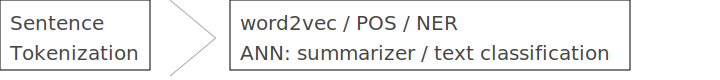

In [33]:
%%svg
<svg width="720" height="80">
    <g>
        <g>
            <rect x="0" y="0" width="150" height="70" fill="#FFF" stroke="#000"></rect>
            <text x="10" y="30" font-family="Verdana" font-size="20" fill="#444">Sentence</text>
            <text x="10" y="60" font-family="Verdana" font-size="20" fill="#444">Tokenization</text>
        </g>

        <g transform="translate(170,0)">
         <polyline fill="none" stroke="#AAA" stroke-width="1" stroke-linecap="round" stroke-linejoin="round" points="
            0.375,0.375 45.63,38.087 0.375,75.8 "/>
        </g>

        <g transform="translate(230,0)">
            <rect x="0" y="0" width="400" height="70" fill="#FFF" stroke="#000"></rect>
            <text x="10" y="30" font-family="Verdana" font-size="20" fill="#444">word2vec / POS / NER</text>
            <text x="10" y="60" font-family="Verdana" font-size="20" fill="#444">ANN: summarizer / text classification</text>
        </g>
    </g>
</svg>

Relevant for text clasification: https://machinelearnings.co/text-classification-using-neural-networks-f5cd7b8765c6

### Tokenization

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [17]:
# first, nltk.download() -> tokenizers/punkt/english.pickle
nltk.download('punkt')
payload_tokenized_lst = []
payload_lines_tokenized_lst = []

for i in tqdm(range(emails_df.shape[0])):
    payload_lines_tokenized_str = sent_tokenize(emails_nlp_df.payload[i])
    payload_lines_tokenized_lst.append(payload_lines_tokenized_str)
    payload_tokenized_str = word_tokenize(emails_nlp_df.payload[i])
    payload_tokenized_lst.append(payload_tokenized_str)

print('payload_tokenized_lst size: %i' % len(payload_tokenized_lst))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guest-x\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|███████████████████████████████████| 10000/10000 [01:28<00:00, 112.43it/s]


payload_tokenized_lst size: 10000


In [18]:
emails_nlp_df = emails_nlp_df.assign(payload_lines_tokenized = pd.Series(payload_lines_tokenized_lst).values)
emails_nlp_df = emails_nlp_df.assign(payload_tokenized = pd.Series(payload_tokenized_lst).values)
emails_nlp_df.head()

,file,payload,payload_lines_tokenized,payload_tokenized
0,allen-p/_sent_mail/1.,Here is our forecast,[Here is our forecast ],"[Here, is, our, forecast]"
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...,[Traveling to have a business meeting takes th...,"[Traveling, to, have, a, business, meeting, ta..."
2,allen-p/_sent_mail/100.,test successful. way to go!!!,"[test successful., way to go!!, !]","[test, successful, ., way, to, go, !, !, !]"
3,allen-p/_sent_mail/1000.,"Randy, Can you send me a schedule of the salar...","[Randy, Can you send me a schedule of the sala...","[Randy, ,, Can, you, send, me, a, schedule, of..."
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.,[Let's shoot for Tuesday at 11:45. ],"[Let, 's, shoot, for, Tuesday, at, 11:45, .]"


### Stemming

In [19]:
from nltk.stem import *
from nltk.stem.porter import *

In [20]:
# Porter stemming of the naive tokenization
stemmer = PorterStemmer()
payload_stemmed_lst = []

for i in tqdm(range(emails_df.shape[0])):
    # emails_nlp_df.payload[i].split(' ') #naive tokenization
    payload_stemmed_str = [stemmer.stem(word) for word in emails_nlp_df.payload_tokenized[i]]
    payload_stemmed_lst.append(payload_stemmed_str)

print('payload_stemmed_lst size: %i' % len(payload_stemmed_lst))

100%|███████████████████████████████████| 10000/10000 [01:10<00:00, 140.94it/s]


payload_stemmed_lst size: 10000


In [21]:
emails_nlp_df = emails_nlp_df.assign(payload_stemmed = pd.Series(payload_stemmed_lst).values)
emails_nlp_df.head()

,file,payload,payload_lines_tokenized,payload_tokenized,payload_stemmed
0,allen-p/_sent_mail/1.,Here is our forecast,[Here is our forecast ],"[Here, is, our, forecast]","[Here, is, our, forecast]"
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...,[Traveling to have a business meeting takes th...,"[Traveling, to, have, a, business, meeting, ta...","[Travel, to, have, a, busi, meet, take, the, f..."
2,allen-p/_sent_mail/100.,test successful. way to go!!!,"[test successful., way to go!!, !]","[test, successful, ., way, to, go, !, !, !]","[test, success, ., way, to, go, !, !, !]"
3,allen-p/_sent_mail/1000.,"Randy, Can you send me a schedule of the salar...","[Randy, Can you send me a schedule of the sala...","[Randy, ,, Can, you, send, me, a, schedule, of...","[Randi, ,, Can, you, send, me, a, schedul, of,..."
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.,[Let's shoot for Tuesday at 11:45. ],"[Let, 's, shoot, for, Tuesday, at, 11:45, .]","[Let, 's, shoot, for, Tuesday, at, 11:45, .]"


### Sentiment analysis

In [22]:
# sentim_analyzer = SentimentAnalyzer()
# all_words_neg = sentim_analyzer.all_words()

from nltk.sentiment.vader import SentimentIntensityAnalyzer

c:\program files\python35\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
# second, nltk.download() -> sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

payload_sentiment_intensity_lst = []
for i in tqdm(range(emails_df.shape[0])):
    payload_sentiment_intensity_str = [sid.polarity_scores(line) for line in payload_tokenized_lst[i]]
    payload_sentiment_intensity_lst.append(payload_sentiment_intensity_str)

print('payload_sentiment_intensity_lst size: %i' % len(payload_sentiment_intensity_lst))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\guest-x\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|████████████████████████████████████| 10000/10000 [03:47<00:00, 43.90it/s]


payload_sentiment_intensity_lst size: 10000


In [24]:
emails_nlp_df = emails_nlp_df.assign(payload_sentiment_intensity_obj = pd.Series(payload_sentiment_intensity_lst).values)
emails_nlp_df.head()

,file,payload,payload_lines_tokenized,payload_tokenized,payload_stemmed,payload_sentiment_intensity_obj
0,allen-p/_sent_mail/1.,Here is our forecast,[Here is our forecast ],"[Here, is, our, forecast]","[Here, is, our, forecast]","[{'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compoun..."
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...,[Traveling to have a business meeting takes th...,"[Traveling, to, have, a, business, meeting, ta...","[Travel, to, have, a, busi, meet, take, the, f...","[{'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compoun..."
2,allen-p/_sent_mail/100.,test successful. way to go!!!,"[test successful., way to go!!, !]","[test, successful, ., way, to, go, !, !, !]","[test, success, ., way, to, go, !, !, !]","[{'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compoun..."
3,allen-p/_sent_mail/1000.,"Randy, Can you send me a schedule of the salar...","[Randy, Can you send me a schedule of the sala...","[Randy, ,, Can, you, send, me, a, schedule, of...","[Randi, ,, Can, you, send, me, a, schedul, of,...","[{'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compoun..."
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.,[Let's shoot for Tuesday at 11:45. ],"[Let, 's, shoot, for, Tuesday, at, 11:45, .]","[Let, 's, shoot, for, Tuesday, at, 11:45, .]","[{'pos': 0.0, 'neg': 0.0, 'neu': 1.0, 'compoun..."


In [25]:
emails_nlp_df.payload_sentiment_intensity_obj[0]

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]

# Next Steps

+ Topic modelling - [radimrehurek.com/gensim/models/word2vec.html](https://radimrehurek.com/gensim/models/word2vec.html)
+ Tensorflow [github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)